In [18]:
import requests
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets
from IPython.display import display

In [19]:
client_id = "42766bfbd4ed4d179f316504c0141132"
client_secret_id = "e5476fa1440e49fdb3ec30a4f3d0357b"

In [29]:
def get_access_token():
    url = "https://accounts.spotify.com/api/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {"grant_type": "client_credentials", "client_id": client_id, "client_secret": client_secret_id}
    response = requests.post(url, headers=headers, data=data)
    return response.json()["access_token"]

access_token = get_access_token()
head = {"Authorization": f"Bearer {access_token}"}

#i took help with chatgpt for this 

With this access token from Spotify so we can make API requests.

In [30]:
def get_artist_id(artist_name):
    url = f"https://api.spotify.com/v1/search?q={artist_name.replace(' ', '%20')}&type=artist"
    response = requests.get(url, headers=head).json()
    return response["artists"]["items"][0]["id"] if response["artists"]["items"] else None

artist_name = "Santhosh Narayanan"  
artist_id = get_artist_id(artist_name)

#i took help with chatgpt for this 

this gets the artist’s unique Spotify ID by searching their name

In [31]:
def get_albums(artist_id):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/albums?include_groups=album&limit=50"
    response = requests.get(url, headers=head).json()
    return [(album["id"], album["name"]) for album in response["items"]]

albums = get_albums(artist_id)

In [38]:
def get_tracks(album_id, album_name):
    url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
    response = requests.get(url, headers=head).json()
    tracks = []
    
    for track in response.get("items", []):
        track_id = track.get("id")
        track_name = track.get("name")
        
        if not track_id:
            continue

        popularity_url = f"https://api.spotify.com/v1/tracks/{track_id}"
        track_response = requests.get(popularity_url, headers=head).json()
        popularity = track_response.get("popularity", 0)  # Default to 0 if missing
        
        tracks.append((track_name, album_name, popularity))
    
    return tracks

#i took help with chatgpt for this 

In [33]:
all_tracks = []
for album_id, album_name in albums:
    all_tracks.extend(get_tracks(album_id, album_name))

df = pd.DataFrame(all_tracks, columns=["Track", "Album", "Popularity"])

df = df.sort_values(by="Popularity", ascending=False)
df_top10 = df.groupby("Album").head(10)

In [34]:
def create_bar_chart(album_name="All"):
    df_filtered = df_top10 if album_name == "All" else df_top10[df_top10["Album"] == album_name]
    df_filtered = df_filtered.sort_values(by="Popularity", ascending=False)
    colors = ["blue" if i < 3 else "gray" for i in range(len(df_filtered))]
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df_filtered["Track"],
        y=df_filtered["Popularity"],
        text=df_filtered["Popularity"],
        textposition="inside",
        marker_color=colors,
        hovertext=df_filtered.apply(lambda row: f"Track: {row['Track']}<br>Popularity: {row['Popularity']}", axis=1),
        hoverinfo="text"
    ))
    
    fig.update_layout(
        title=f"Top 10 Tracks - {album_name}",
        xaxis_title="Track Name",
        yaxis_title="Popularity",
        xaxis_tickangle=-45
    )
    return fig


Dropdown(description='Album:', options=('All', '+', '+-=÷× (Tour Collection)', '+-=÷× (Tour Collection: Live)'…

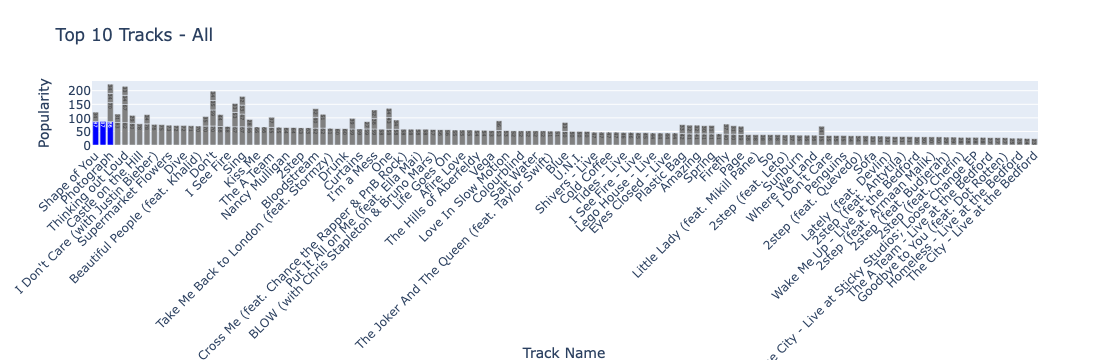

In [39]:
album_options = ["All"] + sorted(df_top10["Album"].unique().tolist())
dropdown = widgets.Dropdown(options=album_options, description="Album:")

def on_change(change):
    if change["name"] == "value":
        fig = create_bar_chart(change["new"])
        fig.show()

dropdown.observe(on_change, names="value")
display(dropdown)
fig = create_bar_chart()
fig.show()

fig.write_html("santhosh_narayanan_track_popularity_by_album.html")



In [37]:
artist_name = "Ed Sheeran"
artist_id = get_artist_id(artist_name)
albums = get_albums(artist_id)

all_tracks = []
for album_id, album_name in albums:
    all_tracks.extend(get_tracks(album_id, album_name))

df = pd.DataFrame(all_tracks, columns=["Track", "Album", "Popularity"])
df = df.sort_values(by="Popularity", ascending=False)
df_top10 = df.groupby("Album").head(10)

display(create_bar_chart())
fig.write_html("ed_sheeran_track_popularity_by_album.html")